In [1]:
import torch
from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments
from progeny_tokenizer import TAPETokenizer
import numpy as np
import math
import random
import scipy
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse
from collections import OrderedDict
import pickle

import matplotlib.pyplot as plt

# Analyze generated sequences

In [2]:
tsv_name = 'generated_seqs/baseline_gen/basegen_seqs260000.tsv'

In [3]:
df = pd.read_table(tsv_name)

In [4]:
df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq
0,0.468239,SSYEEQIKTFIDKFKHVAEMLFHQSEQGMMFYMMNYLMMQFMLFMK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
1,0.577867,STKEMVAKTFLDMFNHEFFIVFLYSFMMAEMLFLFIKFQSTLAQYY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
2,0.609596,SSIEGQAKMFLDKHEHEYEDLFENFFTKMMLFMFMMFMNYNMKAFQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
3,0.714211,STIETVAKSFLDKFNVEAETGFGQFMMQMYAMMMMQLFELMLQLMK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
4,0.787052,KTIEEAAGTMLDKLKAFAKNMLMMMKYEMQAFFMFFNNILKNFLMM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...,...
260649,34.154423,HTGVLQAKTFLDKFAHMSYDLFTLNIMEEFEQAFLKFHMAANAALQ...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260650,34.228806,NTIEIQFKTHLDKFTHEAEDLFYQSSLASMNYNTNITEENVQAMNF...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260651,34.324348,STIEEQYKTFLDKENHEVEDLFYQRSLASMNMNTNITEENAQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260652,34.395195,STIETQAKTMLDLFNHEFFDEFYQSALGSMNKNTIIFEQFFSFLQK...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


## filter out sequences without constant region

In [5]:
wt_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
constant_region = 'NTNITEEN'
wt_cs_ind = wt_seq.index(constant_region)

In [6]:
indices_to_drop = []
dropped_seqs = []
for index, row in df.iterrows():
    seq = row['MT_seq']
    if constant_region not in seq:
        indices_to_drop.append(index)
        dropped_seqs.append(seq)
    else:
        cs_ind = seq.index(constant_region)
        if cs_ind != wt_cs_ind:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)

In [7]:
df = df.drop(indices_to_drop)
print(len(df))

257333


## filter out sequences with invalid token

In [8]:
rejected_tokens = ["<pad>", "<sep>", "<cls>", "<mask>", "<unk>"]

In [9]:
indices_to_drop = []
dropped_seqs = []
for index, row in df.iterrows():
    seq = row['MT_seq']
    
    for rejected_token in rejected_tokens:
        if rejected_token in seq:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)
            break
            

In [10]:
df = df.drop(indices_to_drop)
print(len(df))

257145


In [11]:
df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq
28,2.789537,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
29,2.796858,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
30,2.805789,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
31,2.808174,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
32,2.808599,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
...,...,...,...,...,...,...
260646,33.955925,STIEEQFKTFLDTFNHEAEDLEPQYSLANMNYNTNITEENPMNMNM...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260647,33.976833,DTIEEFFKTFLDKFNHNAEDKFYQSSLASRNYNTNITEENVQSMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260650,34.228806,NTIEIQFKTHLDKFTHEAEDLFYQSSLASMNYNTNITEENVQAMNF...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
260651,34.324348,STIEEQYKTFLDKENHEVEDLFYQRSLASMNMNTNITEENAQNMAN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...


## Analyze hamming distance

In [12]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
 
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [13]:
hamming_dist_list = []

In [14]:
wt_seq = df.iloc[0]['WT_seq']

In [15]:
wt_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

In [16]:
for index, row in df.iterrows():
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(gen_seq, wt_seq)
    hamming_dist_list.append(h_dist)

In [17]:
hamming_dist_list

[10,
 8,
 7,
 7,
 9,
 11,
 7,
 6,
 8,
 17,
 11,
 8,
 7,
 9,
 10,
 11,
 6,
 11,
 9,
 9,
 8,
 6,
 10,
 12,
 7,
 10,
 10,
 10,
 8,
 8,
 5,
 12,
 9,
 10,
 8,
 8,
 11,
 6,
 7,
 6,
 7,
 9,
 9,
 10,
 11,
 9,
 7,
 9,
 8,
 5,
 8,
 5,
 8,
 10,
 9,
 8,
 12,
 5,
 11,
 10,
 8,
 8,
 8,
 11,
 9,
 10,
 5,
 9,
 6,
 6,
 8,
 7,
 6,
 15,
 11,
 7,
 9,
 11,
 19,
 12,
 11,
 12,
 10,
 10,
 7,
 9,
 11,
 9,
 8,
 13,
 8,
 10,
 8,
 7,
 10,
 7,
 8,
 4,
 12,
 8,
 8,
 15,
 11,
 7,
 10,
 8,
 8,
 10,
 9,
 5,
 12,
 16,
 6,
 9,
 9,
 10,
 15,
 19,
 9,
 8,
 10,
 10,
 8,
 8,
 9,
 9,
 6,
 17,
 13,
 8,
 13,
 9,
 9,
 9,
 6,
 17,
 4,
 10,
 5,
 13,
 9,
 9,
 6,
 10,
 7,
 14,
 8,
 8,
 15,
 9,
 7,
 10,
 8,
 9,
 5,
 9,
 12,
 9,
 12,
 10,
 11,
 10,
 7,
 11,
 17,
 13,
 9,
 9,
 9,
 12,
 15,
 7,
 13,
 6,
 9,
 12,
 14,
 12,
 8,
 15,
 14,
 12,
 9,
 12,
 7,
 5,
 6,
 5,
 11,
 11,
 11,
 13,
 11,
 9,
 11,
 12,
 10,
 17,
 9,
 6,
 10,
 6,
 11,
 6,
 10,
 9,
 15,
 6,
 6,
 12,
 8,
 14,
 17,
 9,
 10,
 12,
 7,
 17,
 9,
 4,
 9,
 11,
 13,
 14,
 6,
 1

In [18]:
print("Hamming distance stats")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))

Hamming distance stats
max:  51
min:  2
median:  11.0
mean:  11.146749888195377


Text(0.5, 1.0, 'Hamming Distance from WT seq')

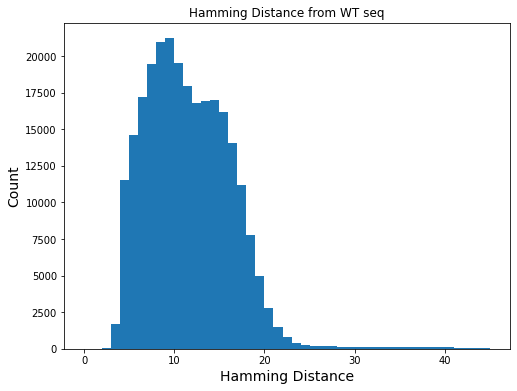

In [19]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, label='generated', bins=[i for i in range(46)])
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Count", size=14)
plt.title("Hamming Distance from WT seq")
# plt.legend(loc='upper left')

hamming distance for generator training data

In [20]:
gen_train_data = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'

In [21]:
gen_train_df = pd.read_pickle(gen_train_data)

In [22]:
wt_seq = gen_train_df.iloc[0]['WT_seq']

In [23]:
wt_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

In [24]:
gen_train_hamming_dist_list = []
for index, row in gen_train_df.iterrows():
    train_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, wt_seq)
    gen_train_hamming_dist_list.append(h_dist)

Text(0.5, 1.0, 'Hamming Distance from WT seq')

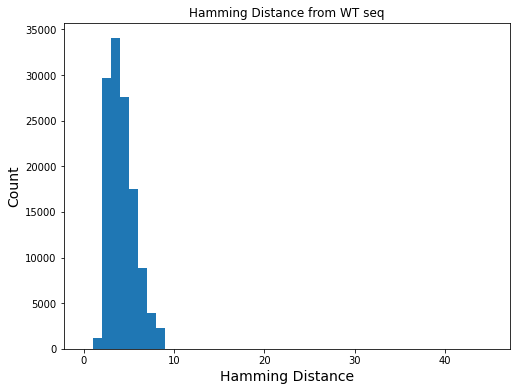

In [25]:
plt.figure(figsize=(8,6))
plt.hist(gen_train_hamming_dist_list, label='train_data', bins=[i for i in range(46)])
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Count", size=14)
plt.title("Hamming Distance from WT seq")
# plt.legend(loc='upper left')

In [65]:
len(hamming_dist_list)

257145

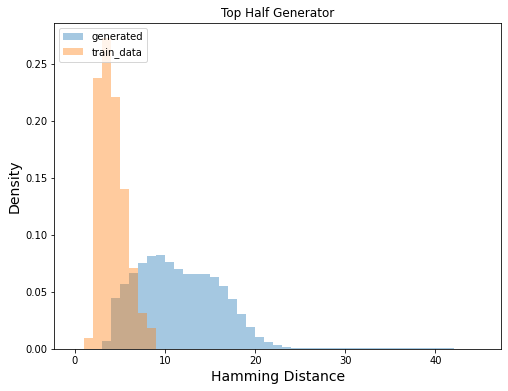

In [26]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top Half Generator")
plt.legend(loc='upper left')

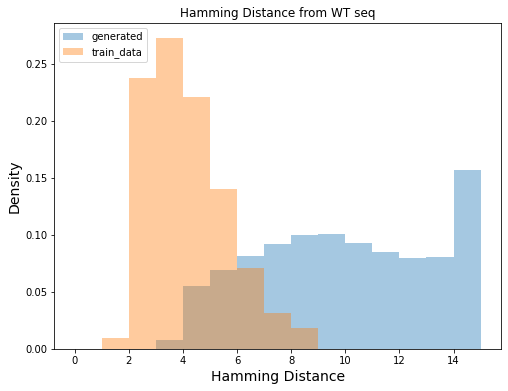

In [27]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(16)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(16)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Hamming Distance from WT seq")
plt.legend(loc='upper left')

# Analyze ddG values of gen 10K

In [28]:
from tape.metrics import spearmanr

In [29]:
results_tsv_name = "../../prot5_alvin/utils/foldx_sim_results/tophalf-basegen_top10K-Dscore_250Kgen/results_full.tsv"

In [30]:
ddG_df = pd.read_table(results_tsv_name)

In [31]:
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
0,5.934434,ITIEEQAKTFLDKFNHEAEVLFYQSSLASMMYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.697247
1,5.935354,STIEEQAKTFLDKFNHEAEDLFYQSNLTSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,0.662897
2,5.935360,STIEEQAQFFLDKFNLEAEDLMYQSMLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.234055
3,5.935919,STIEEQAKTFLDKFNHMAEDLFYQSSLASENYNTNITEENVQNMYN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.513946
4,5.937118,STIEEQAKTFLDDFQHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.298550
...,...,...,...,...,...,...,...
9995,3.212985,SSIEEQAETFLDKFVHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.065390
9996,3.213139,STIEEQAKTFLDKFRHEFEDLFYQMSLASMNYNTNITEENFQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-9.127630
9997,3.213400,STIEEQAKTFLDKFNHEAEDLFYQSMLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-2.146290
9998,3.213930,SYIEEQAKTFNDKFNGEAERLFYQFSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-6.087310


In [32]:
disc_pred_list = ddG_df['disc_pred']
ddG_list = ddG_df['ddG']

In [33]:
disc_ddG_cor = spearmanr(disc_pred_list, ddG_list)

In [34]:
disc_ddG_cor

0.6198012084678118

In [35]:
# Disc-predicted most stable ones first
ddG_df = ddG_df.sort_values(by='disc_pred', ascending=True)

In [36]:
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.789537,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.354120
5751,2.796858,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.210830
5752,2.805789,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.740590
5753,2.808174,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
5754,2.808599,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.217820
...,...,...,...,...,...,...,...
5745,6.657531,STIEEQAKTFLDFFNHEAGDLFYQSSLASMNYNTNITEENVQNMSN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.487757
5746,6.657921,STIEEQLQQFLDKFKHEAEMLFYRSQLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.181264
5747,6.658039,STMEEQAKTFLKKFNHRAEDLFNQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.772040
5748,6.659424,STIEEQAKTFLDKFNHEAEDLFNQSLLASMNYNTNITEENAQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.768130


In [37]:
top_half_stable_df = ddG_df[:len(ddG_df)//2]

In [38]:
top_half_stable_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.789537,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.354120
5751,2.796858,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.210830
5752,2.805789,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.740590
5753,2.808174,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
5754,2.808599,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.217820
...,...,...,...,...,...,...,...
5495,5.008011,SDIEDQAKTELDKFNHEAEDLFYFSSLASMNYNTNITEENTQTMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.350779
5496,5.008556,STIEEQAKTFLQKFFREAEYLFYQSRKASMLYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.479898
5497,5.008722,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNE...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.129700
5498,5.009111,SLIEEQVMIFLYKFNFEAERLFEQSMLAQMNYNTNITEENVRNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.718460


In [39]:
gen_train_ddG_list = gen_train_df['ddG']

In [40]:
len(ddG_list)

10000

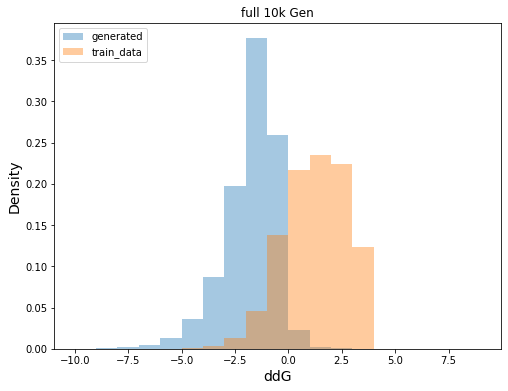

In [41]:
plt.figure(figsize=(8,6))
plt.hist(ddG_list, density=True, label='generated', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

In [42]:
len(top_half_stable_df['ddG'])

5000

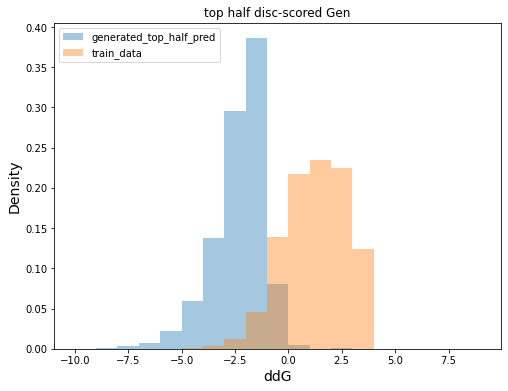

In [43]:
plt.figure(figsize=(8,6))
plt.hist(top_half_stable_df['ddG'], density=True, label='generated_top_half_pred', bins=[i for i in range(-10, 10)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.4)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("top half disc-scored Gen")
plt.legend(loc='upper left')

In [44]:
np.max(top_half_stable_df['ddG'])

25.9089

In [45]:
np.min(top_half_stable_df['ddG'])

-9.12763

In [46]:
np.mean(top_half_stable_df['ddG'])

-2.2860534653999998

In [47]:
np.median(top_half_stable_df['ddG'])

-2.060035

In [48]:
np.max(gen_train_ddG_list)

3.5751

In [49]:
np.min(gen_train_ddG_list)

-6.59818

In [50]:
np.mean(gen_train_ddG_list)

1.26221709496

In [51]:
np.median(gen_train_ddG_list)

1.3439199999999998

## plot top 100, 1k and 10k distribution

topk:  10000
topk_disc_ddG_cor:  0.6198012084678118
topk:  1000
topk_disc_ddG_cor:  0.4173222670781675
topk:  100
topk_disc_ddG_cor:  -0.05219321932193219


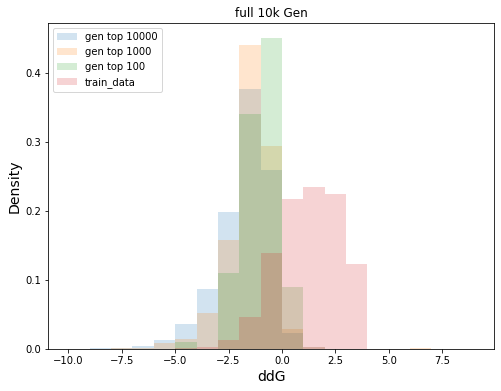

In [52]:
topk_hist_list = [10000, 1000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)



plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("full 10k Gen")
plt.legend(loc='upper left')

topk:  10000
topk_disc_ddG_cor:  0.6198012084678118
topk:  100
topk_disc_ddG_cor:  -0.05219321932193219


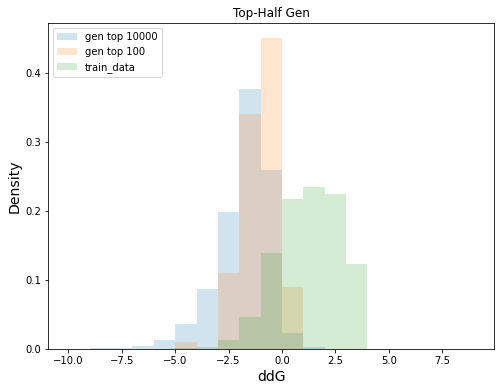

In [62]:
topk_hist_list = [10000, 100]

plt.figure(figsize=(8,6))

for topk in topk_hist_list:
    topk_ddG_list = ddG_list[:topk]
    topk_disc_pred_list = disc_pred_list[:topk]
    topk_disc_ddG_cor = spearmanr(topk_disc_pred_list, topk_ddG_list)
    print("topk: ", topk)
    print("topk_disc_ddG_cor: ", topk_disc_ddG_cor)

    plt.hist(topk_ddG_list, density=True, label='gen top {}'.format(topk), bins=[i for i in range(-10, 10)], alpha=0.2)


plt.hist(gen_train_ddG_list, density=True, label='train_data', bins=[i for i in range(-10, 10)], alpha=0.2)
plt.xlabel("ddG", size=14)
plt.ylabel("Density", size=14)
plt.title("Top-Half Gen")
plt.legend(loc='upper left')

top 10, 100, 1000 by disc ranking

In [54]:
ddG_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.789537,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.354120
5751,2.796858,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.210830
5752,2.805789,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.740590
5753,2.808174,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.706710
5754,2.808599,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.217820
...,...,...,...,...,...,...,...
5745,6.657531,STIEEQAKTFLDFFNHEAGDLFYQSSLASMNYNTNITEENVQNMSN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.487757
5746,6.657921,STIEEQLQQFLDKFKHEAEMLFYRSQLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-0.181264
5747,6.658039,STMEEQAKTFLKKFNHRAEDLFNQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.772040
5748,6.659424,STIEEQAKTFLDKFNHEAEDLFNQSLLASMNYNTNITEENAQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-1.768130


In [55]:
topK_list = [10, 100, 1000, 10000]

In [56]:
topK_df = ddG_df[:10]
topK_df

,disc_pred,MT_seq,PDB,Chain,Start_index,WT_seq,ddG
5750,2.789537,SDIEEQAKTFLDKFNHEAEDLFYQSSLRSMVYNTNITEENIQNMNR...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-3.35412
5751,2.796858,SSIEEQAKTFLDKFNHEAEDYFYQSSLASMNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.21083
5752,2.805789,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.74059
5753,2.808174,SDIEEQAKTFLDRFNHEAEDLFYQSSLASANYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.70671
5754,2.808599,SDIEEQAKTFLDKFLHEAEDLFYQSSLASFNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.21782
5755,2.809425,SDIEEQAKTFLDKFDHAAEDLFYMSSLQSMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.85485
5756,2.810728,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQIMNL...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.20230
5757,2.811584,SDIEEQAKTFLDKFNHEAEDLFYFSMLASMNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.02916
5758,2.811855,SDIEEQAKTFLGKFNHEAEDLFYQMSLASMNYNTNITEENVQNMNY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.59374
5759,2.812827,SDIERQAKTFLEKFNHNAEDLFYQFSLASMNLNTNITEENVQNMNY...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,-4.74791


In [57]:
train_75pct =  np.percentile(gen_train_ddG_list, 25)

In [58]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    
    PCI_75pct = np.sum(topK_df['ddG'] < train_75pct) / len(topK_df['ddG'])
    print("PCI_75pct: ", PCI_75pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


PCI_75pct = np.sum(gen_train_ddG_list < train_75pct) / len(gen_train_ddG_list)
print("PCI_75pct: ", PCI_75pct)

PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.35412
min:  -4.85485
mean:  -4.3658030000000005
median:  -4.40578
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -1.82828
min:  -7.66052
mean:  -4.051433500000001
median:  -3.8778949999999996
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  2.78988
min:  -9.12763
mean:  -3.465055221
median:  -3.2556599999999998
PCI_75pct:  0.997
PCI_WT:  0.997
____________________
top K:  10000
max:  25.9089
min:  -9.12763
mean:  -1.7412032977000003
median:  -1.518215
PCI_75pct:  0.9855
PCI_WT:  0.9743
____________________
top half:  5000
max:  25.9089
min:  -9.12763
mean:  -2.2860534653999998
median:  -2.060035
PCI_75pct:  0.9948
PCI_WT:  0.9928
____________________
train dataset:  125000
max:  3.5751
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
PCI_75pct:  0.25
PCI_WT:  0.200864
____________________


In [59]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100, 95, 90, 85, 80, 75]

In [60]:
for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("max: ", np.max(topK_df['ddG']))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("max: ", np.max(tophalf_df['ddG']))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
max:  -3.35412
min:  -4.85485
mean:  -4.3658030000000005
median:  -4.40578
PCI_100pct:  0.0
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  100
max:  -1.82828
min:  -7.66052
mean:  -4.051433500000001
median:  -3.8778949999999996
PCI_100pct:  0.03
PCI_95pct:  1.0
PCI_90pct:  1.0
PCI_85pct:  1.0
PCI_80pct:  1.0
PCI_75pct:  1.0
PCI_WT:  1.0
____________________
top K:  1000
max:  2.78988
min:  -9.12763
mean:  -3.465055221
median:  -3.2556599999999998
PCI_100pct:  0.029
PCI_95pct:  0.991
PCI_90pct:  0.995
PCI_85pct:  0.996
PCI_80pct:  0.997
PCI_75pct:  0.997
PCI_WT:  0.997
____________________
top K:  10000
max:  25.9089
min:  -9.12763
mean:  -1.7412032977000003
median:  -1.518215
PCI_100pct:  0.004
PCI_95pct:  0.638
PCI_90pct:  0.8625
PCI_85pct:  0.9459
PCI_80pct:  0.9741
PCI_75pct:  0.9855
PCI_WT:  0.9743
____________________
top half:  5000
max:  25.9089
min:  -9.12763
mean:  -2.2860534653999998
median:

In [64]:
topK_list = [10, 100, 1000, 10000]
percentile_list = [100]

for topK in topK_list:
    topK_df = ddG_df[:topK]
    print("top K: ", len(topK_df))
    print("min: ", np.min(topK_df['ddG']))
    print("mean: ", np.mean(topK_df['ddG']))
    print("median: ", np.median(topK_df['ddG']))
    print("max: ", np.max(topK_df['ddG']))
    
    for percentile in percentile_list:
        pct = np.percentile(gen_train_ddG_list, 100-percentile)
        PCI_pct = np.sum(topK_df['ddG'] < pct) / len(topK_df['ddG'])
        print("PCI_{}pct: ".format(percentile), PCI_pct)
    
    PCI_WT = np.sum(topK_df['ddG'] < 0) / len(topK_df['ddG'])
    print("PCI_WT: ", PCI_WT)
    
    print("_"*20)
    
tophalf_df = ddG_df[:len(ddG_df)//2]
print("top half: ", len(tophalf_df))
print("min: ", np.min(tophalf_df['ddG']))
print("mean: ", np.mean(tophalf_df['ddG']))
print("median: ", np.median(tophalf_df['ddG']))
print("max: ", np.max(tophalf_df['ddG']))


# PCI_75pct = np.sum(tophalf_df['ddG'] < train_75pct) / len(tophalf_df['ddG'])
# print("PCI_75pct: ", PCI_75pct)

for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(tophalf_df['ddG'] < pct) / len(tophalf_df['ddG'])
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(tophalf_df['ddG'] < 0) / len(tophalf_df['ddG'])
print("PCI_WT: ", PCI_WT)

print("_"*20)


# training data distribution
print("train dataset: ", len(gen_train_ddG_list))
print("min: ", np.min(gen_train_ddG_list))
print("mean: ", np.mean(gen_train_ddG_list))
print("median: ", np.median(gen_train_ddG_list))
print("max: ", np.max(gen_train_ddG_list))


for percentile in percentile_list:
    pct = np.percentile(gen_train_ddG_list, 100-percentile)
    PCI_pct = np.sum(gen_train_ddG_list < pct) / len(gen_train_ddG_list)
    print("PCI_{}pct: ".format(percentile), PCI_pct)


PCI_WT = np.sum(gen_train_ddG_list < 0) / len(gen_train_ddG_list)
print("PCI_WT: ", PCI_WT)

print("_"*20)

top K:  10
min:  -4.85485
mean:  -4.3658030000000005
median:  -4.40578
max:  -3.35412
PCI_100pct:  0.0
PCI_WT:  1.0
____________________
top K:  100
min:  -7.66052
mean:  -4.051433500000001
median:  -3.8778949999999996
max:  -1.82828
PCI_100pct:  0.03
PCI_WT:  1.0
____________________
top K:  1000
min:  -9.12763
mean:  -3.465055221
median:  -3.2556599999999998
max:  2.78988
PCI_100pct:  0.029
PCI_WT:  0.997
____________________
top K:  10000
min:  -9.12763
mean:  -1.7412032977000003
median:  -1.518215
max:  25.9089
PCI_100pct:  0.004
PCI_WT:  0.9743
____________________
top half:  5000
min:  -9.12763
mean:  -2.2860534653999998
median:  -2.060035
max:  25.9089
PCI_100pct:  0.0078
PCI_WT:  0.9928
____________________
train dataset:  125000
min:  -6.59818
mean:  1.26221709496
median:  1.3439199999999998
max:  3.5751
PCI_100pct:  0.0
PCI_WT:  0.200864
____________________
